# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [1]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import json
import zipfile

import pandas as pd
import numpy as np

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     HalvingGridSearchCV, RandomizedSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (precision_score, recall_score,
                             roc_auc_score, roc_curve, f1_score)

import matplotlib.pyplot as plt
import seaborn as sns


# <font color='#11a642' size='6'> **Загрузка данных**

In [3]:
def load_dataset(from_kaggle=False) -> pd.DataFrame:
  '''
  Функция скачивает данные с сайта kaggle, если установлен from_kaggle=True,
  инчае архив считывается по ссылке с моегого гугл диска (такой способ удобен тем, у кого нет доступа к kaggle)
  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s4e7
  else:
    !gdown 1HG4oNC-EfEK7DsXDfKKfb5BtgzevyZZO
  # распаковка архива
  zip_ref = zipfile.ZipFile('playground-series-s4e7.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission

In [4]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle=False)

Downloading...
From (original): https://drive.google.com/uc?id=1HG4oNC-EfEK7DsXDfKKfb5BtgzevyZZO
From (redirected): https://drive.google.com/uc?id=1HG4oNC-EfEK7DsXDfKKfb5BtgzevyZZO&confirm=t&uuid=f21f5487-2cfa-4de8-8682-5d9560be6a8f
To: /content/playground-series-s4e7.zip
100% 259M/259M [00:03<00:00, 72.8MB/s]


In [5]:
# это данные даны для примера, в таком виде необходимо сделать выборку и загрузить на kaggle
#  (для тех, кто хочет увидеть себя в лидерборде и оценить на сколько ваше решение лучше/хуже остальных)
df_sample_submission.head()

,id,Response
0,11504798,0.5
1,11504799,0.5
2,11504800,0.5
3,11504801,0.5
4,11504802,0.5


In [6]:
# это тестовые данные, для которых необходимо предсказать target, то есть применить модель,
#  которую вы разработаете на данных df_train
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [7]:
# на этих данных дальше необходимо разработать модель
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


## <font color='#11a642' size='5'> Определим роли для независимых признаков

In [8]:
id = 'id'
target = 'Response'

In [9]:
# на основании описание данных https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data/discussion/516324
features_cat_from_description = ['Region_Code', 'Vehicle_Age', 'Policy_Sales_Channel']

In [10]:
features_num = [feature for feature in df_train.select_dtypes(include='number').columns.to_list()
               if feature not in [id, target, *features_cat_from_description]]
features_num

['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Vintage']

In [11]:
features_cat = [feature for feature in df_train.columns.to_list() if feature
                not in [id, target, *features_num]]
features_cat

['Gender',
 'Region_Code',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel']

In [12]:
for column in features_cat:
  try:
    df_train[column] = df_train[column].astype(int).astype(object)
  except Exception as e:
    print(e)

invalid literal for int() with base 10: 'Male'
invalid literal for int() with base 10: '1-2 Year'
invalid literal for int() with base 10: 'Yes'


In [13]:
features_cat_bin = ['Gender', ]

# <font color='#11a642' size='6'> **Функции**

In [14]:
def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Предсказание вероятностей на обучающей и тестовой выборке
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Расчет AUC-ROC
    roc_auc_train = roc_auc_score(y_train, y_train_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    print(f"ROC-AUC Train: {roc_auc_train:.2f}")
    print(f"ROC-AUC Test: {roc_auc_test:.2f}")

    # Построение ROC-кривой
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC Curve Train')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC Curve Test')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({type(model).__name__})')
    plt.legend()
    plt.show()

    # Поиск порога, максимизирующего F1-score
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_proba >= t) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold: {optimal_threshold:.2f}")

    # Пересчет метрик с учетом оптимального порога
    y_train_pred_optimal = (y_train_proba >= optimal_threshold).astype(int)
    y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

    train_precision = precision_score(y_train, y_train_pred_optimal)
    train_recall = recall_score(y_train, y_train_pred_optimal)
    test_precision = precision_score(y_test, y_test_pred_optimal)
    test_recall = recall_score(y_test, y_test_pred_optimal)

    print(f"Optimal Training Precision: {train_precision:.2f}")
    print(f"Optimal Training Recall: {train_recall:.2f}")
    print(f"Optimal Test Precision: {test_precision:.2f}")
    print(f"Optimal Test Recall: {test_recall:.2f}")

    metrics = {
        'params': [
            'Training_Precision', 'Test_Precision',
            'Training_Recall', 'Test_Recall',
            'ROC_AUC_Train', 'ROC_AUC_Test'
        ],
        'values': [
            train_precision, test_precision,
            train_recall, test_recall,
            roc_auc_train, roc_auc_test
        ]
    }
    return metrics

# <font color='#11a642' size='6'> **Разведочный анализ данных**

## <font color='#11a642' size='5'> Оцените размер вашего датасета


1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов



In [15]:
# Сколько ГБ ваш датасет
# ваш код

In [16]:
# Сколько строк и столбцов
# ваш код

## <font color='#11a642' size='5'> Анализ категориальных признаков


In [17]:
# ваш код

## <font color='#11a642' size='5'> Анализ пропусков


In [18]:
df_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [19]:
# ваш код

# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

In [20]:
%%time
X_train, X_test, y_train, y_test = train_test_split(df_train[[*features_cat, *features_num]],
                                                    df_train[target],
                                                    test_size=0.2,
                                                    stratify=df_train[target],
                                                    random_state=42)
X_train.shape, X_test.shape

CPU times: user 9.76 s, sys: 891 ms, total: 10.7 s
Wall time: 10.7 s


((9203838, 10), (2300960, 10))

# <font color='#11a642' size='6'> **Подготовка данных к обучению**

In [21]:
bin_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [22]:
cat_pipe = Pipeline(
    [
        ('cat_encoding', TargetEncoder()),
        ('scaling', StandardScaler())
    ]
)

In [23]:
num_pipe = Pipeline(
    [
        ('scaling', StandardScaler())
    ]
)

In [24]:
data_preprocessor = ColumnTransformer(
    [
        ('bin_pipe', bin_pipe, features_cat_bin),
        ('cat_pipe', cat_pipe, [feature for feature in features_cat if feature not in features_cat_bin]),
        ('num_pipe', num_pipe, features_num),
    ],
    remainder='passthrough'
)

In [25]:
%%time
X_train_transform = data_preprocessor.fit_transform(X_train, y_train)

CPU times: user 30.8 s, sys: 5.8 s, total: 36.6 s
Wall time: 36.7 s


In [26]:
%%time
df_test_transform = data_preprocessor.transform(df_test)

CPU times: user 4.57 s, sys: 1.36 s, total: 5.93 s
Wall time: 5.91 s


In [27]:
%%time
X_test_transform = data_preprocessor.transform(X_test)

CPU times: user 1.96 s, sys: 256 ms, total: 2.21 s
Wall time: 2.21 s


In [28]:
columns = data_preprocessor.get_feature_names_out()

# Создание DataFrame из трансформированных данных
X_train_transform_df = pd.DataFrame(X_train_transform, columns=columns)
X_test_transform_df = pd.DataFrame(X_test_transform, columns=columns)

In [29]:
df_test_transform_df = pd.DataFrame(df_test_transform, columns=columns)

In [30]:
df_test_transform_df.head()

,bin_pipe__Gender_Male,cat_pipe__Region_Code,cat_pipe__Vehicle_Age,cat_pipe__Vehicle_Damage,cat_pipe__Policy_Sales_Channel,num_pipe__Age,num_pipe__Driving_License,num_pipe__Previously_Insured,num_pipe__Annual_Premium,num_pipe__Vintage
0,0.0,-0.806192,-1.074825,-1.005153,-1.146694,-1.226250,0.044424,-0.928633,-1.691597,0.801514
1,1.0,1.393129,0.720858,0.994873,0.777066,0.574669,0.044424,-0.928633,0.426598,-0.511345
2,1.0,-0.652626,0.720858,0.994873,0.950805,0.574669,0.044424,-0.928633,-1.691597,1.339160
3,0.0,-0.806192,-1.074825,-1.005153,-1.084663,-1.092848,0.044424,1.076852,-0.362324,-0.611372
4,1.0,0.887943,0.720858,-1.005153,0.777066,0.841472,0.044424,-0.928633,0.221907,-0.198760


In [31]:
df_test_transform_df.shape

(7669866, 10)

# <font color='#11a642' size='6'> **Modeling**

## <font color='#11a642' size='5'> LogisticRegression

In [32]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_transform_df, y_train)
y_pred = logreg.predict(X_test_transform_df)

print('Logistic Regression accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with all the features: 0.8761
CPU times: user 15.5 s, sys: 3.99 s, total: 19.5 s
Wall time: 15.1 s


ROC-AUC Train: 0.85
ROC-AUC Test: 0.85


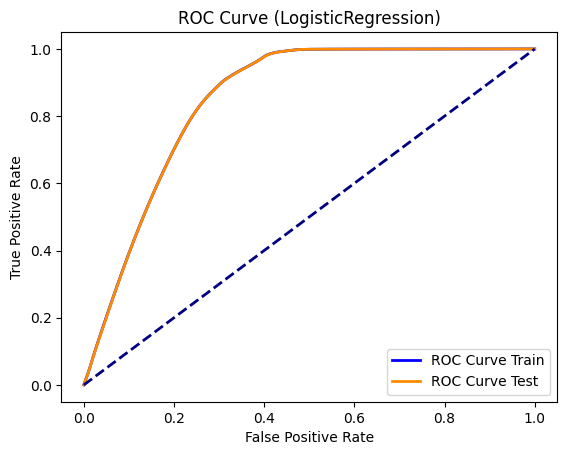

Optimal Threshold: 0.22
Optimal Training Precision: 0.32
Optimal Training Recall: 0.80
Optimal Test Precision: 0.32
Optimal Test Recall: 0.80


In [33]:
logreg_metrics = calculate_metrics_and_plot_roc(logreg, X_train_transform_df, y_train, X_test_transform_df, y_test)

In [34]:
logreg_metrics

{'params': ['Training_Precision',
  'Test_Precision',
  'Training_Recall',
  'Test_Recall',
  'ROC_AUC_Train',
  'ROC_AUC_Test'],
 'values': [0.31696285645084504,
  0.3169534400977893,
  0.804584085289745,
  0.8044217206337541,
  0.8492882943687112,
  0.8490552379469054]}

## <font color='#11a642' size='5'> Logreg with PCA

`explained variance ratio` - это отношение объясненной дисперсии к общей дисперсии данных. В контексте PCA, explained variance ratio показывает, какую долю дисперсии в данных объясняют каждая из главных компонент. Это позволяет оценить, насколько хорошо главные компоненты представляют данные и какую информацию они удерживают.

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_transform_df)
pca.explained_variance_ratio_

array([0.36386254, 0.14115815, 0.12125352, 0.10805468, 0.10731538,
       0.06401556, 0.03266005, 0.0256932 , 0.01832879, 0.01765813])

In [36]:
# Собственные векторы (главные компоненты)
eigenvectors = pca.components_
eigenvectors[:2]

array([[ 0.050666  ,  0.28409356,  0.4747863 ,  0.38249798,  0.46868683,
         0.42477732, -0.03467049, -0.37503126,  0.05276043, -0.01611802],
       [ 0.00950265,  0.42651698,  0.15398407, -0.47877594,  0.08382657,
         0.25535111, -0.07771182,  0.49901764,  0.48624542,  0.03649733]])

In [37]:
# Первая и вторая главные компоненты
first_principal_component = X_train_pca[:, 0]
second_principal_component = X_train_pca[:, 1]

# Собственные векторы (главные компоненты)
eigenvectors = pca.components_

# Создание DataFrame для удобного вывода
eigenvectors_df = pd.DataFrame(eigenvectors, columns=X_train_transform_df.columns)
eigenvectors_first_two = eigenvectors_df.iloc[:2]

# Вывод результатов
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("\nEigenvectors (First Two Principal Components):")
print(eigenvectors_first_two)


Explained Variance Ratio: [0.36386254 0.14115815 0.12125352 0.10805468 0.10731538 0.06401556
 0.03266005 0.0256932  0.01832879 0.01765813]

Eigenvectors (First Two Principal Components):
   bin_pipe__Gender_Male  cat_pipe__Region_Code  cat_pipe__Vehicle_Age  \
0               0.050666               0.284094               0.474786   
1               0.009503               0.426517               0.153984   

   cat_pipe__Vehicle_Damage  cat_pipe__Policy_Sales_Channel  num_pipe__Age  \
0                  0.382498                        0.468687       0.424777   
1                 -0.478776                        0.083827       0.255351   

   num_pipe__Driving_License  num_pipe__Previously_Insured  \
0                  -0.034670                     -0.375031   
1                  -0.077712                      0.499018   

   num_pipe__Annual_Premium  num_pipe__Vintage  
0                  0.052760          -0.016118  
1                  0.486245           0.036497  


In [38]:
# %%time
# plt.figure(figsize=(8, 6))
# sc = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train, cmap='viridis', edgecolor='k', s=50)
# plt.xlabel('Первая главная компонента')
# plt.ylabel('3 главная компонента')
# plt.title('Проекция на первые две главные компоненты с учетом таргета')
# plt.grid(True)
# plt.show()

In [39]:
# %%time
# plt.figure(figsize=(8, 6))
# sc = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
# plt.xlabel('1 главная компонента')
# plt.ylabel('2 главная компонента')
# plt.title('Проекция на первые две главные компоненты с учетом таргета')
# plt.grid(True)
# plt.show()

In [40]:
# %%time
# plt.figure(figsize=(8, 6))
# sc = plt.scatter(X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', edgecolor='k', s=50)
# plt.xlabel('2 главная компонента')
# plt.ylabel('3 главная компонента')
# plt.title('Проекция на первые две главные компоненты с учетом таргета')
# plt.grid(True)
# plt.show()


Этот код выполняет анализ главных компонент (PCA) и определяет количество компонент, необходимых для сохранения 95% дисперсии (вариации) данных.

In [41]:
pca= PCA()
pca.fit(X_train_transform_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.8) + 1
print('The number of dimensions required to preserve 80% of variance is',dim)

The number of dimensions required to preserve 95% of variance is 5


In [42]:
pca.explained_variance_ratio_

array([0.36386254, 0.14115815, 0.12125352, 0.10805468, 0.10731538,
       0.06401556, 0.03266005, 0.0256932 , 0.01832879, 0.01765813])

In [ ]:
cumsum

<ipython-input-43-3b4f58ee1a53>:3: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,14,1)


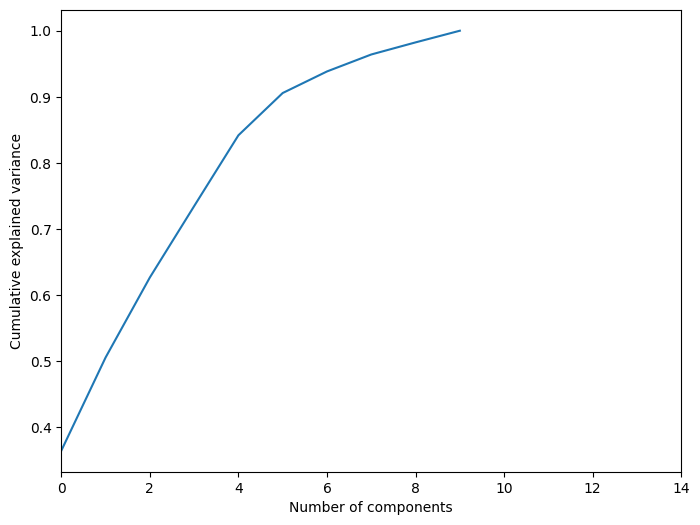

In [43]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [44]:
pca= PCA(n_components=dim)
pca.fit(X_train_transform_df)

PCA(n_components=5)

In [45]:
pca_train = pca.transform(X_train_transform_df)

In [46]:
pca_test = pca.transform(X_test_transform_df)

In [47]:
logreg_pca = LogisticRegression(max_iter=200)
logreg_pca.fit(pca_train, y_train)
y_pred = logreg_pca.predict(pca_test)

ROC-AUC Train: 0.84
ROC-AUC Test: 0.84


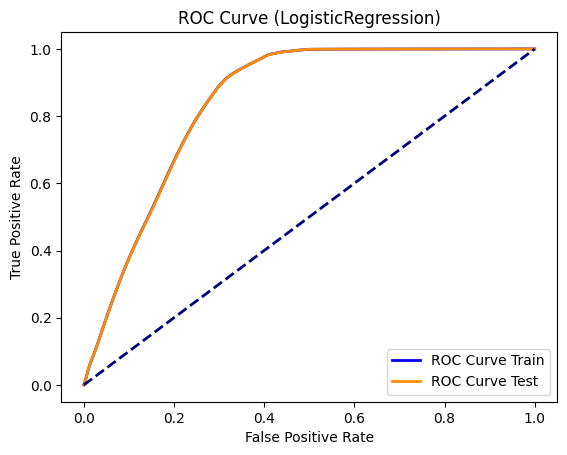

Optimal Threshold: 0.24
Optimal Training Precision: 0.31
Optimal Training Recall: 0.81
Optimal Test Precision: 0.31
Optimal Test Recall: 0.81


In [48]:
logreg_pca_metrics = calculate_metrics_and_plot_roc(logreg_pca, pca_train, y_train, pca_test, y_test)

In [49]:
logreg_pca_metrics

{'params': ['Training_Precision',
  'Test_Precision',
  'Training_Recall',
  'Test_Recall',
  'ROC_AUC_Train',
  'ROC_AUC_Test'],
 'values': [0.3053305989450422,
  0.30521235188643114,
  0.8138319345398204,
  0.8137640806750244,
  0.8435489531712232,
  0.843222716334554]}

In [51]:
pca_df_test_transform = pca.transform(df_test_transform_df)

In [52]:
y_pred_for_submit = logreg_pca.predict_proba(pca_df_test_transform)

# <font color='#11a642' size='6'> **Опционально, для тех, кто хочет сравнить свое решение с другими решениями на kaggle. Применение алгоритма к тестовой выборке df_test и сабмит решения на kaggle**

In [53]:
df_test['Response'] = y_pred_for_submit[:,1]

In [54]:
df_test[[id, 'Response']].to_csv('/content/submissions.csv', index=False)

In [55]:
# загрузка данных на kaggle
drive.mount('/content/drive')
# установим kaggle
!pip install kaggle -q
!mkdir ~/.kaggle
# копируем kaggle.json (предварительно, необходимо сгенерить токен на
# сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
!cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
!kaggle competitions submit -c playground-series-s4e7 -f /content/submissions.csv -m "pca 2 submit"

Mounted at /content/drive
100% 218M/218M [00:02<00:00, 104MB/s]
Successfully submitted to Binary Classification of Insurance Cross Selling 